# Part 3

## Predictive modeling

#### Table of Content

1. [Importing Data](#section_1)<br>
2. [Cleaning Data](#section_2)<br>
3. [Exploring Data](#section_3)<br>
4. [Modeling](#section_4)<br>
    a. [Logistic Regession](#section_4a)<br>
    b. [Decision Tree Classifier](#section_4b)<br>
    c. [Random Forest Classifier](#section_4c)<br>
    d. [MultinomialNB](#section_4d)<br>
    e. [XGBClassifier](#section_4e) <br> 
5. [Model Selection](#section_5)<br>
6. [Model Insight](#section_6)

<a id='section_1'></a>
### 1. Importing Data

In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


<a id='section_2'></a>
### 2. Cleaning Data


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [6]:
# Replacing all nan's
df['phone'].replace([np.nan], 'Unknown', inplace = True)

In [7]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [8]:
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

<div class="alert alert-block alert-success">
Since the last trip was on July 1st at midnight, that would make all of June the last 30 days. If a person used the service in the month of June, they will be considered an active customer.
</div>

In [9]:
# Make the active customer column to make predictions
df['active_customer'] = np.nan
df['active_customer'] = np.where(df['last_trip_date'] >= '2014-06-01', 1, df['active_customer'])
df['active_customer'].replace([np.nan], 0, inplace = True)

In [10]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_customer
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1.0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0.0


<a id='section_3'></a>
### 3. Exploring Data


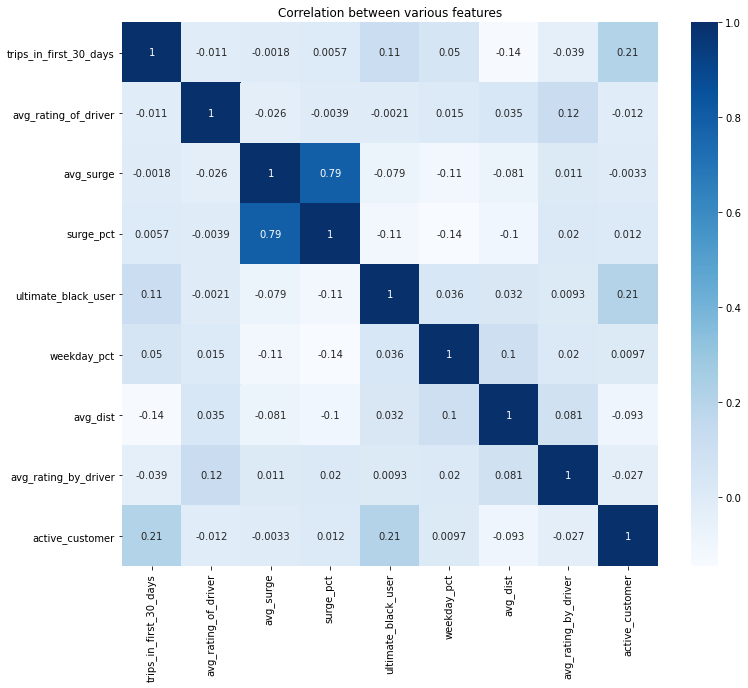

In [11]:
plt.figure(figsize=(12,10))
p=sns.heatmap(df.corr(), annot=True,cmap ='Blues')
plt.title('Correlation between various features');

<div class="alert alert-block alert-success">
Based on the correlation map, three numerical features have stronger correlations: trips in the frist 30 days, surge percentage, and ultimate blak user.
    
Lets explore those features further. 
</div>

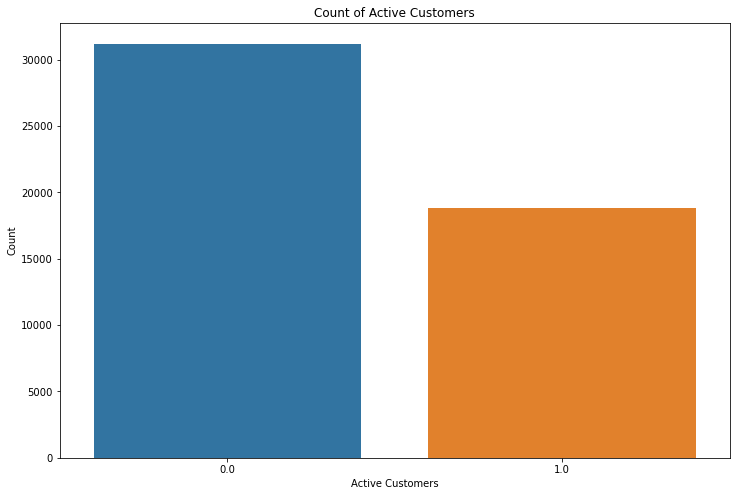

In [12]:
plt.figure(figsize = [12, 8])

sns.countplot(data = df, x = 'active_customer')
plt.title('Count of Active Customers')
plt.xlabel('Active Customers')
plt.ylabel('Count')
plt.show();

In [13]:
df['active_customer'].sum()/ df['active_customer'].count()

0.37608

<div class="alert alert-block alert-success">
37% of users are active customers still after 6 months. 
</div>

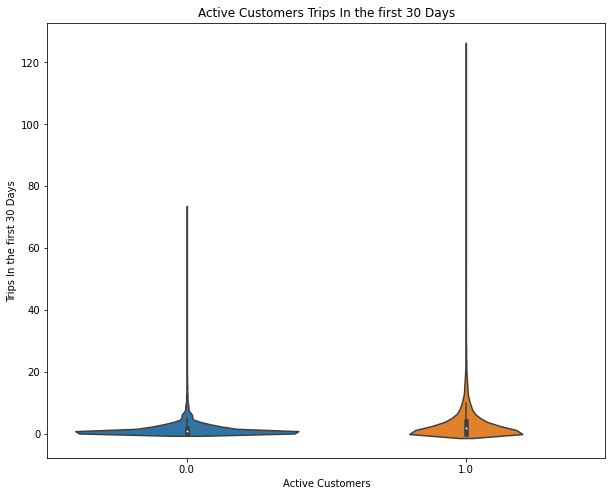

In [14]:
plt.figure(figsize = [10, 8]) 
sns.violinplot(data = df, x = 'active_customer', y = 'trips_in_first_30_days')
plt.title('Active Customers Trips In the first 30 Days')
plt.xlabel('Active Customers')
plt.ylabel('Trips In the first 30 Days');

In [15]:
df_0 = df[df['active_customer'] == 0]
df_1 = df[df['active_customer'] == 1]

In [16]:
df_0['trips_in_first_30_days'].describe()

count    31196.000000
mean         1.658482
std          2.654222
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         73.000000
Name: trips_in_first_30_days, dtype: float64

In [17]:
df_1['trips_in_first_30_days'].describe()

count    18804.000000
mean         3.306318
std          4.986743
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

<div class="alert alert-block alert-success">
It seems that current active users used the service more frequently than non-active customers in the first month that they signed up. The mean of active customers is about 1.65 trips more per the first month than non active customers 
</div>

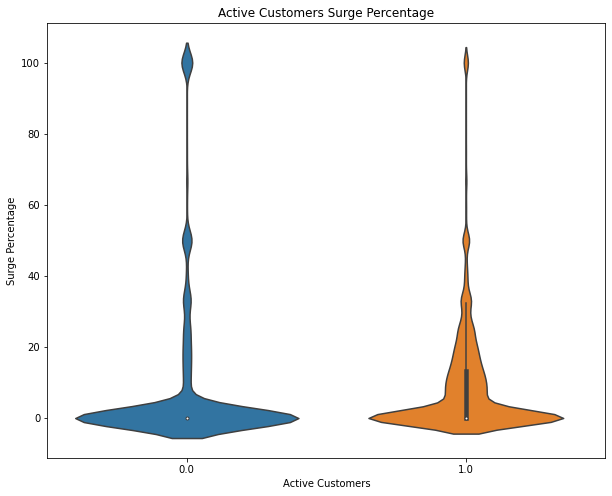

In [18]:
plt.figure(figsize = [10, 8]) 
sns.violinplot(data = df, x = 'active_customer', y = 'surge_pct')
plt.title('Active Customers Surge Percentage')
plt.xlabel('Active Customers')
plt.ylabel('Surge Percentage');

In [19]:
df['surge_pct'].describe()

count    50000.000000
mean         8.849536
std         19.958811
min          0.000000
25%          0.000000
50%          0.000000
75%          8.600000
max        100.000000
Name: surge_pct, dtype: float64

In [20]:
df_0['surge_pct'].describe()

count    31196.000000
mean         8.666739
std         22.179139
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        100.000000
Name: surge_pct, dtype: float64

In [21]:
df_1['surge_pct'].describe()

count    18804.000000
mean         9.152797
std         15.588704
min          0.000000
25%          0.000000
50%          0.000000
75%         13.300000
max        100.000000
Name: surge_pct, dtype: float64

<div class="alert alert-block alert-success">
The distribution is smaller in non active customers. The mean is slightly higher in the active users, which makes me think active users are ok paying for the service, while non active users are less likely to take trips with high surge charges. 
</div>

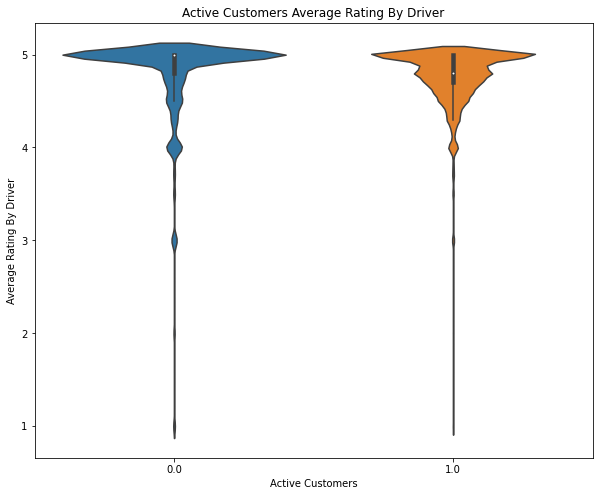

In [22]:
plt.figure(figsize = [10, 8]) 
sns.violinplot(data = df, x = 'active_customer', y = 'avg_rating_by_driver')
plt.title('Active Customers Average Rating By Driver')
plt.xlabel('Active Customers')
plt.ylabel('Average Rating By Driver');

<div class="alert alert-block alert-success">
Non-active customers are more likely to have a rating of a 5 by the driver. This is probabiliy because they have taken less trips. The more trips they take, the more likely that number would be to drop slightly.  
</div>

#### Now lets look at Catergorical Data

In [23]:
user_type = df.groupby(['active_customer', 'ultimate_black_user']).size()
user_type = user_type.reset_index(name='count')
user_type = user_type.sort_values('active_customer')
user_type = user_type.pivot(index = 'active_customer', columns = 'ultimate_black_user', values = 'count')

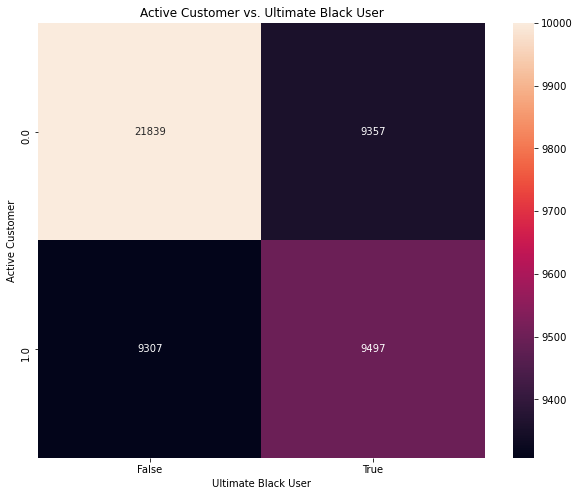

In [24]:
plt.figure(figsize = [10, 8]) 
sns.heatmap(user_type, annot = True, fmt = 'd', vmax=10000)
plt.title('Active Customer vs. Ultimate Black User')
plt.ylabel('Active Customer')
plt.xlabel('Ultimate Black User');

<div class="alert alert-block alert-success">
It is clear that a large number of non-active customers are also not Ultimate Black users.
</div>

In [25]:
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

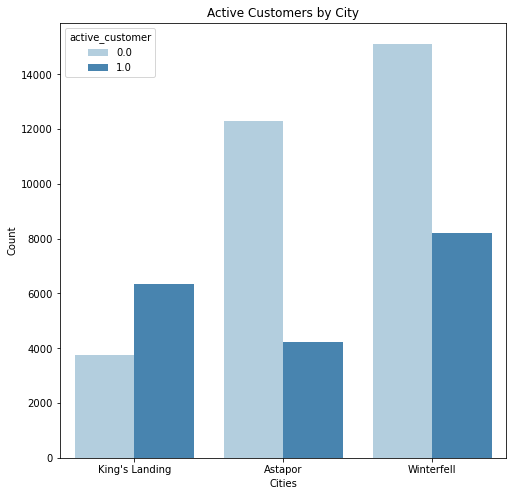

In [26]:
plt.figure(figsize = [8, 8])

sns.countplot(data = df, x = 'city', hue = 'active_customer', palette = 'Blues')
plt.title('Active Customers by City')
plt.xlabel('Cities')
plt.ylabel('Count')
plt.show();

<div class="alert alert-block alert-success">
King's Landing has the largerst percent of active uses in the city. It is also the only city with more active customers than non-active customers.
</div>

In [27]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Unknown      396
Name: phone, dtype: int64

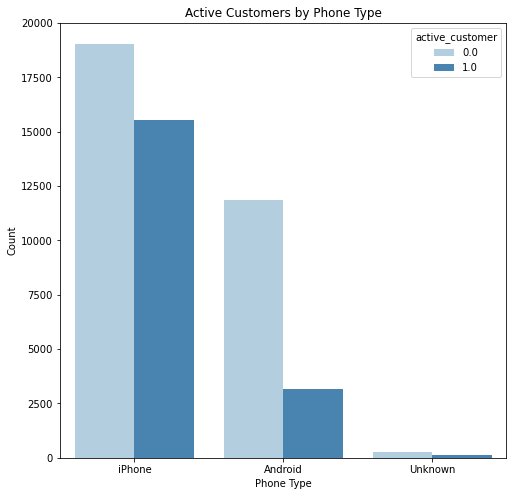

In [28]:
plt.figure(figsize = [8, 8])

sns.countplot(data = df, x = 'phone', hue = 'active_customer', palette = 'Blues')
plt.title('Active Customers by Phone Type')
plt.xlabel('Phone Type')
plt.ylabel('Count')
plt.show();

<div class="alert alert-block alert-success">
While every phone type has more non-active customers than active customers, but a larger percent of iPhone users are still active customers.  
</div>

<a id='section_4'></a>
### 4. Modeling


In [29]:
df = df.drop(['last_trip_date'], axis = 1)

In [30]:
df['ultimate_black_user'].replace(True, 1, inplace = True)
df['ultimate_black_user'].replace(False, 0, inplace = True)
df['avg_rating_of_driver'].replace([np.nan], 'Unknown', inplace = True)
df['avg_rating_by_driver'].replace([np.nan], 'Unknown', inplace = True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  object 
 4   avg_surge               50000 non-null  float64
 5   phone                   50000 non-null  object 
 6   surge_pct               50000 non-null  float64
 7   ultimate_black_user     50000 non-null  int64  
 8   weekday_pct             50000 non-null  float64
 9   avg_dist                50000 non-null  float64
 10  avg_rating_by_driver    50000 non-null  object 
 11  active_customer         50000 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 4.6+ MB


In [32]:
catergorical_features = ['city', 'signup_date', 'phone', 'avg_rating_of_driver', 'avg_rating_by_driver']

In [33]:
#Creating labels for catergorical features
for feature in catergorical_features:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(list(df[feature].values.astype('str')))
    df[feature] = label_encoder.transform(list(df[feature].values.astype('str'))) 
    print("for feature {0}: label-encoding was done succesfully".format(feature))

for feature city: label-encoding was done succesfully
for feature signup_date: label-encoding was done succesfully
for feature phone: label-encoding was done succesfully
for feature avg_rating_of_driver: label-encoding was done succesfully
for feature avg_rating_by_driver: label-encoding was done succesfully


In [34]:
X = df.drop(columns='active_customer', axis = 1)
y = df['active_customer']

cols = X.columns

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.fit_transform(X)

In [35]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=47)

<a id='section_4a'></a>
### 4a. Logistic Regession


In [37]:
model = LogisticRegression()

#Hyperparameter tuning
parameters = {'class_weight': ['balanced', None],
              'penalty' : ['l1', 'l2', 'none'],
              'C': np.arange(0.5, 20.0, 0.5),
              'fit_intercept': [True, False],
             'multi_class': ['auto','ovr','multinomial']}

In [38]:
lg_random = RandomizedSearchCV(estimator = model, param_distributions = parameters,
                               verbose = False, n_iter = 10, cv = 5, random_state=42, n_jobs = -1)
lg_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", lg_random.best_estimator_)

 Results from Random Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=12.0, fit_intercept=False, multi_class='ovr',
                   penalty='none')


/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64972287 0.64981446 0.64976866 0.64967708        nan        nan
 0.64908176 0.64976866 0.64967708        nan]
  warnings.warn(
/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [39]:
y_pred = lg_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[6096 3198]
 [3359 6065]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.64      0.66      0.65      9294
         1.0       0.65      0.64      0.65      9424

    accuracy                           0.65     18718
   macro avg       0.65      0.65      0.65     18718
weighted avg       0.65      0.65      0.65     18718



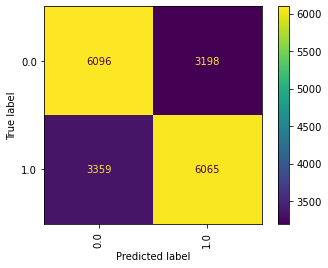

In [40]:
plot_confusion_matrix(lg_random, X_test, y_test,xticks_rotation='vertical')

In [41]:
lg_acc_score = accuracy_score(y_test, y_pred)
lg_pre_score = precision_score(y_test, y_pred)
lg_rec_score = recall_score(y_test, y_pred)
lg_f1_score = f1_score(y_test, y_pred)

<a id='section_4b'></a>
### 4b. Decision Tree Classifier


In [42]:
model = DecisionTreeClassifier()

#Hyperparameter tuning
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_leaf_nodes': [3,4,5,10,15,20,25,50,75,100,125,150,200, None]}

In [43]:
dt_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               random_state=42, n_jobs = -1)
dt_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", dt_random.best_estimator_)

 Results from Random Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(max_depth=50, max_features='sqrt', max_leaf_nodes=100,
                       min_samples_leaf=25, min_samples_split=100)


In [44]:
y_pred = dt_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[7312 1982]
 [2767 6657]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.73      0.79      0.75      9294
         1.0       0.77      0.71      0.74      9424

    accuracy                           0.75     18718
   macro avg       0.75      0.75      0.75     18718
weighted avg       0.75      0.75      0.75     18718



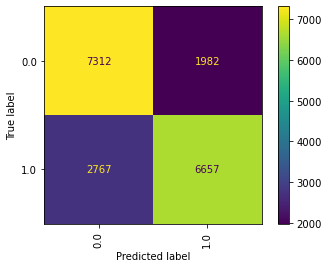

In [45]:
plot_confusion_matrix(dt_random, X_test, y_test,xticks_rotation='vertical')

In [46]:
dt_acc_score = accuracy_score(y_test, y_pred)
dt_pre_score = precision_score(y_test, y_pred)
dt_rec_score = recall_score(y_test, y_pred)
dt_f1_score = f1_score(y_test, y_pred)

<a id='section_4c'></a>
### 4c. Random Forest Classifier


In [47]:
model = RandomForestClassifier()

#Hyperparameter tuning
parameters = {'n_estimators': [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
              'criterion': ['gini', 'entropy'],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'min_weight_fraction_leaf': [0.01, 0.1, 0.25, 0.001, 0.5, 0.75, 0.9],
               'bootstrap': [True, False]}

In [48]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.75605607        nan        nan 0.75676593        nan
 0.5014883         nan        nan 0.71415483]
  warnings.warn(


 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=25, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=400,
                       min_weight_fraction_leaf=0.01, n_estimators=40)


In [49]:
y_pred = rf_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[7301 1993]
 [2590 6834]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.74      0.79      0.76      9294
         1.0       0.77      0.73      0.75      9424

    accuracy                           0.76     18718
   macro avg       0.76      0.76      0.76     18718
weighted avg       0.76      0.76      0.75     18718



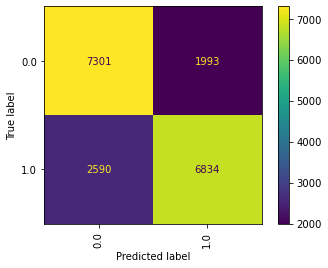

In [50]:
plot_confusion_matrix(rf_random, X_test, y_test,xticks_rotation='vertical')

In [51]:
rf_acc_score = accuracy_score(y_test, y_pred)
rf_pre_score = precision_score(y_test, y_pred)
rf_rec_score = recall_score(y_test, y_pred)
rf_f1_score = f1_score(y_test, y_pred)

<a id='section_4d'></a>
### 4d. MultinomialNB


In [52]:
model = MultinomialNB()

#Hyperparameter tuning
parameters = {"alpha":[0.001,0.005,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                "fit_prior":[True,False]}

In [53]:
mnb_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
mnb_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", mnb_random.best_estimator_)

 Results from Random Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=0.5, fit_prior=False)


In [54]:
y_pred = mnb_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[6370 2924]
 [4557 4867]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.58      0.69      0.63      9294
         1.0       0.62      0.52      0.57      9424

    accuracy                           0.60     18718
   macro avg       0.60      0.60      0.60     18718
weighted avg       0.60      0.60      0.60     18718



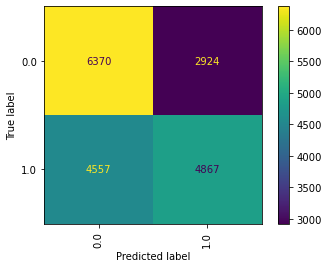

In [55]:
plot_confusion_matrix(mnb_random, X_test, y_test,xticks_rotation='vertical')

In [56]:
mnb_acc_score = accuracy_score(y_test, y_pred)
mnb_pre_score = precision_score(y_test, y_pred)
mnb_rec_score = recall_score(y_test, y_pred)
mnb_f1_score = f1_score(y_test, y_pred)

<a id='section_4e'></a>
### 4e. XGBClassifier


In [57]:
model = XGBClassifier()

#Hyperparameter tuning
parameters = {'n_estimators':[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.25, 0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'class_weight':[None,'balanced'],
          'max_depth': [1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
          'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3]
         }

In [58]:
xgb_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
xgb_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", xgb_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:19:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 Results from Random Search 

 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [59]:
y_pred = xgb_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[7501 1793]
 [1381 8043]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.84      0.81      0.83      9294
         1.0       0.82      0.85      0.84      9424

    accuracy                           0.83     18718
   macro avg       0.83      0.83      0.83     18718
weighted avg       0.83      0.83      0.83     18718



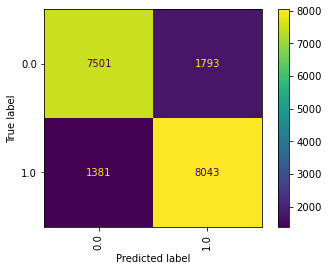

In [60]:
plot_confusion_matrix(xgb_random, X_test, y_test,xticks_rotation='vertical')

In [61]:
xgb_acc_score = accuracy_score(y_test, y_pred)
xgb_pre_score = precision_score(y_test, y_pred)
xgb_rec_score = recall_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)

<a id='section_5'></a>
### 5. Model Selection


In [62]:
# Creating a models table
model_selection=pd.DataFrame({'Model':['Logistic Regession', 'Decision Tree Classifier', 'Random Forest Classifier',
                                        'MultinomialNB', 'XGBClassifier'], 
                             'Accuracy Score':[lg_acc_score, dt_acc_score, rf_acc_score, mnb_acc_score, xgb_acc_score],
                             'Precision Score':[lg_pre_score, dt_pre_score, rf_pre_score, mnb_pre_score,xgb_pre_score],
                             'Recall Score':[lg_rec_score, dt_rec_score, rf_rec_score, mnb_rec_score, xgb_rec_score],
                             'F1 Score':[lg_f1_score, dt_f1_score, rf_f1_score, mnb_f1_score, xgb_f1_score]})

In [63]:
model_selection

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score
0,Logistic Regession,0.649695,0.654755,0.643570,0.649114
1,Decision Tree Classifier,0.746287,0.770575,0.706388,0.737087
2,Random Forest Classifier,0.755155,0.774215,0.725170,0.748890
3,MultinomialNB,0.600331,0.624695,0.516447,0.565437
4,XGBClassifier,0.830431,0.817710,0.853459,0.835202


<div class="alert alert-block alert-success">
While Decision trees and Random Forest preformed pretty well, the clear best model is the XGBClassifier. It outscored all other models in all four metrics, Accuracy, Precision, Recall, and F1 scores. It was also the only model to score above a 0.8 in any of the metrics, and did it in all four. 
</div>

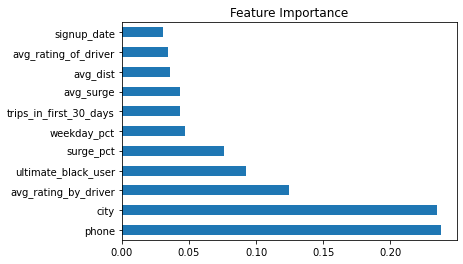

In [64]:
feat_importances = pd.Series(xgb_random.best_estimator_.feature_importances_, index = cols)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importance')
plt.show()

<a id='section_6'></a>
### 6. Model Insight

The XGBClassifier model produced the following as the top 5 features:
1. phone
2. city
3. avg_rating_by_driver
4. ultimate_black_user
5. surge_pct

With this knowledge, Ultimate can make a few take aways:
1. Ultimate should market to iphone users more heavily. They are more likely remain active customers in the 6 month period.
2. King's Landing has more retention than any other city. More marketing efforts should be applied there since they are more likely to remain active customers.
4. If a person signs up for Ultimate Black, they are more likely to remain an active member, so marketing should promote Ultimate Black.
5. Surge percentage average is higher for active users, so customers who remain active do not seem to mind surge prices. Non-active customers may not be willing to pay the surge cost, and so become inactive. A promotion could be applied to lower or eliminate surge pricing for a period of sign-up. Then the customers might try the service more, really enjoy it and continue to use it once their promotional time ends. 